# PlantTraits2024

# Imports

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import psutil

In [2]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchmetrics
import torch.nn as nn
import timm
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [3]:
from torch.cuda.amp import autocast, GradScaler

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:50'

In [4]:
backbones = [
    'convnextv2_tiny.fcmae',
    'efficientnet_b0',
    "resnet50",
    "swin_large_patch4_window12_384.ms_in22k_ft_in1k",
    "swin_base_patch4_window12_384.ms_in22k_ft_in1k",
    "swinv2_base_window8_256.ms_in1k",
    "convnext_base.fb_in22k_ft_in1k"
]

In [5]:
import wandb

wandb.init(
    project="plant-traits-2024",
    entity="laukikk",
    name="swin_tiny",
    

    config = {
        "seed": 69,
        "train_val_split": 0.1,
        "learning_rate": 0.00001,
        "epochs": 5,
        "batch_size": 32,
        "weight_decay": 0.01,
        "image_size": 224,
        "backbone": "swin_tiny_patch4_window7_224.ms_in22k",
        "note": ""
    }
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Functions

In [6]:
def display_random_image(train_df, test_df):
    '''display a random training and test image'''
    fig, ax = plt.subplots(1, 2)
    random_train = train_df.sample(1)
    random_test = test_df.sample(1)
    img_train = Image.open(random_train['file_path'].values[0])
    img_test = Image.open(random_test['file_path'].values[0])
    ax[0].imshow(img_train)
    ax[1].imshow(img_test)
    ax[0].set_title('Training Image')
    ax[1].set_title('Test Image')
    plt.title('Random Images')
    plt.show()

# PreProcessing

In [7]:
BASE_PATH = "/kaggle/input/planttraits2024/"
CLASSES = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
AUX_CLASSES = ['X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']

In [8]:
def select_features_train(train_src):
    features = ['id','MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m3',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m4',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m4',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m6',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m7',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m8',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m9',
 'SOIL_bdod_0.5cm_mean_0.01_deg',
 'SOIL_bdod_60.100cm_mean_0.01_deg',
 'SOIL_cec_0.5cm_mean_0.01_deg',
 'SOIL_ocd_0.5cm_mean_0.01_deg',
 'SOIL_phh2o_0.5cm_mean_0.01_deg',
 'SOIL_phh2o_100.200cm_mean_0.01_deg',
 'SOIL_phh2o_15.30cm_mean_0.01_deg',
 'SOIL_phh2o_30.60cm_mean_0.01_deg',
 'SOIL_phh2o_5.15cm_mean_0.01_deg',
 'SOIL_phh2o_60.100cm_mean_0.01_deg',
 'SOIL_sand_0.5cm_mean_0.01_deg',
 'SOIL_sand_100.200cm_mean_0.01_deg',
 'SOIL_sand_15.30cm_mean_0.01_deg',
 'SOIL_sand_30.60cm_mean_0.01_deg',
 'SOIL_sand_5.15cm_mean_0.01_deg',
 'SOIL_sand_60.100cm_mean_0.01_deg',
 'SOIL_silt_0.5cm_mean_0.01_deg',
 'SOIL_silt_100.200cm_mean_0.01_deg',
 'SOIL_silt_15.30cm_mean_0.01_deg',
 'SOIL_silt_30.60cm_mean_0.01_deg',
 'SOIL_silt_5.15cm_mean_0.01_deg',
 'SOIL_silt_60.100cm_mean_0.01_deg',
 'WORLDCLIM_BIO15_precipitation_seasonality',
 'WORLDCLIM_BIO4_temperature_seasonality',
 ]
    
    modified_df = train_src[features]
    
    additional_features = [
    'X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean'
    ]

    # Read the additional features from their respective files
    additional_features_train = pd.concat(
        [train_src[feature] for feature in additional_features], 
        axis=1
    )

    # Concatenate the selected features and the additional six features
    combined_df = pd.concat([modified_df, additional_features_train], axis=1)
    
    return combined_df


In [9]:
def select_features_test(df):
    features = ['id','MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m3',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m4',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m4',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m6',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m7',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m8',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m9',
 'SOIL_bdod_0.5cm_mean_0.01_deg',
 'SOIL_bdod_60.100cm_mean_0.01_deg',
 'SOIL_cec_0.5cm_mean_0.01_deg',
 'SOIL_ocd_0.5cm_mean_0.01_deg',
 'SOIL_phh2o_0.5cm_mean_0.01_deg',
 'SOIL_phh2o_100.200cm_mean_0.01_deg',
 'SOIL_phh2o_15.30cm_mean_0.01_deg',
 'SOIL_phh2o_30.60cm_mean_0.01_deg',
 'SOIL_phh2o_5.15cm_mean_0.01_deg',
 'SOIL_phh2o_60.100cm_mean_0.01_deg',
 'SOIL_sand_0.5cm_mean_0.01_deg',
 'SOIL_sand_100.200cm_mean_0.01_deg',
 'SOIL_sand_15.30cm_mean_0.01_deg',
 'SOIL_sand_30.60cm_mean_0.01_deg',
 'SOIL_sand_5.15cm_mean_0.01_deg',
 'SOIL_sand_60.100cm_mean_0.01_deg',
 'SOIL_silt_0.5cm_mean_0.01_deg',
 'SOIL_silt_100.200cm_mean_0.01_deg',
 'SOIL_silt_15.30cm_mean_0.01_deg',
 'SOIL_silt_30.60cm_mean_0.01_deg',
 'SOIL_silt_5.15cm_mean_0.01_deg',
 'SOIL_silt_60.100cm_mean_0.01_deg',
 'WORLDCLIM_BIO15_precipitation_seasonality',
 'WORLDCLIM_BIO4_temperature_seasonality',
 ]
    
    modified_df = df[features]
    

    
    
    return modified_df


In [10]:
# Read the data
train_src = pd.read_csv(BASE_PATH + 'train.csv')
test_df = pd.read_csv(BASE_PATH + 'test.csv')

train_src = select_features_train(train_src)
test_df = select_features_test(test_df)

# Add the file path to the data
train_src['file_path'] = train_src['id'].apply(lambda x: BASE_PATH + 'train_images/' + str(x) + '.jpeg')
test_df['file_path'] = test_df['id'].apply(lambda x: BASE_PATH + 'test_images/' + str(x) + '.jpeg')

# Dropping the auxiliary classes
# train_src = train_src.drop(columns=AUX_CLASSES)

# Removing the Outliers
for column in CLASSES:
    lower_quantile = train_src[column].quantile(0.005)
    upper_quantile = train_src[column].quantile(0.985)  
    train_src = train_src[(train_src[column] >= lower_quantile) & (train_src[column] <= upper_quantile)]
    
    
# Standardizing the data
FEATURE_COLUMNS = [col for col in train_src.columns if col not in ['id', 'file_path'] + CLASSES]

scaler = StandardScaler()
scaler.fit(train_src[FEATURE_COLUMNS])

train_src_scaled = scaler.transform(train_src[FEATURE_COLUMNS])
test_df_scaled = scaler.transform(test_df[FEATURE_COLUMNS])

train_src_scaled = pd.DataFrame(train_src_scaled, columns=FEATURE_COLUMNS, index=train_src.index)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=FEATURE_COLUMNS, index=test_df.index)

train_src_scaled[['id', 'file_path'] + CLASSES] = train_src[['id', 'file_path'] + CLASSES]
test_df_scaled[['id', 'file_path']] = test_df[['id', 'file_path']]

train_src = train_src_scaled
test_df = test_df_scaled

# Logging the ouput features
# y_train = np.zeros_like(train_src[CLASSES], dtype=np.float32)
# for target_idx, target in enumerate(CLASSES):
#     v = train[target].values
#     v = np.log10(v)
#     y_train[:, target_idx] = v

In [11]:
# Train Validate Split
train_df, valid_df = train_test_split(train_src, test_size=wandb.config.train_val_split, random_state=wandb.config.seed)

In [12]:
N_TRAIN_SAMPLES = len(train_df)
N_STEPS_PER_EPOCH = (N_TRAIN_SAMPLES // wandb.config.batch_size)
N_STEPS = N_STEPS_PER_EPOCH * wandb.config.epochs + 1

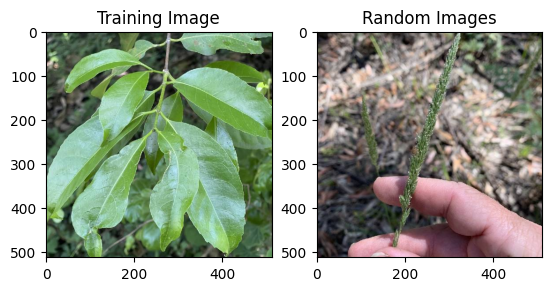

In [13]:
display_random_image(train_df, test_df)

# DataSet

In [14]:
class PlantDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
        self.feature_columns = [col for col in dataframe.columns if col not in ['id', 'file_path'] + CLASSES]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        ancillary_data = torch.tensor(self.dataframe.iloc[idx][self.feature_columns].values.astype(np.float32))
        labels = torch.tensor(self.dataframe.iloc[idx][CLASSES].values.astype(np.float32))

        return image, ancillary_data, labels
    
# Data Augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.5, hue=0.1)], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.85, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomRotation(degrees=(1, 5)),
])
    
# Define transformations
transform = transforms.Compose([
    augmentation_transforms,
    transforms.Resize((wandb.config.image_size, wandb.config.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the dataset
train_dataset = PlantDataset(train_df, transform=transform)
valid_dataset = PlantDataset(valid_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True, num_workers=psutil.cpu_count())
valid_loader = DataLoader(valid_dataset, batch_size=wandb.config.batch_size, shuffle=True, num_workers=psutil.cpu_count())

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# DataLoader

In [16]:
class PlantTraitPredictor(nn.Module):
    def __init__(self, num_ancillary_features):
        super(PlantTraitPredictor, self).__init__()
        self.cnn = timm.create_model(wandb.config.backbone, pretrained=True, num_classes=0)
        
        # Classifier to merge image and ancillary features
        self.fc1 = nn.Linear(self.cnn.num_features + num_ancillary_features, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 6)  # Output 6 values for regression

    def forward(self, images, ancillary_data):
        img_features = self.cnn(images)
        combined_features = torch.cat((img_features, ancillary_data), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = PlantTraitPredictor(num_ancillary_features=len(train_df.columns) - len(CLASSES) - 2)
model.to(device)
wandb.watch(model, log='all')

model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

[]

In [17]:
optimizer = torch.optim.AdamW(
    params = model.parameters(),
    lr = wandb.config.learning_rate,
    weight_decay = wandb.config.weight_decay
)

lr_scheduler = OneCycleLR(
    optimizer, 
    max_lr=wandb.config.learning_rate,
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=1e1,
    final_div_factor=1e1,
    epochs = wandb.config.epochs,
    steps_per_epoch=len(train_loader)
)

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count

MAE = torchmetrics.regression.MeanAbsoluteError().to('cuda')
R2 = torchmetrics.regression.R2Score(num_outputs=len(CLASSES), multioutput='uniform_average').to('cuda')
LOSS = AverageMeter()

VAL_MAE = torchmetrics.regression.MeanAbsoluteError().to('cuda')
VAL_R2 = torchmetrics.regression.R2Score(num_outputs=len(CLASSES), multioutput='uniform_average').to('cuda')

LOSS_FN = nn.SmoothL1Loss()

scaler = GradScaler()

In [18]:
# EPOCHS
for epoch in range(wandb.config.epochs):
    # Reset metrics for each epoch
    MAE.reset()
    R2.reset()
    LOSS.reset()
    
    # TRAINING
    model.train()
    for images, ancillary_data, labels in tqdm(train_loader):
        images = images.to(device)
        ancillary_data = ancillary_data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        with autocast():
            outputs = model(images, ancillary_data)
            loss = LOSS_FN(outputs, labels)
            
        LOSS.update(loss)
        
        scaler.scale(loss).backward()  # Scales the loss to prevent gradient underflow
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()
        
        MAE.update(outputs, labels)
        R2.update(outputs, labels)
        
    train_loss = LOSS.avg
    train_r2 = R2.compute().item()
    train_mae = MAE.compute().item()
    
    # VALIDATION
    MAE.reset()
    R2.reset()
    LOSS.reset()
    
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for images, ancillary_data, labels in tqdm(valid_loader):
            images = images.to(device)
            ancillary_data = ancillary_data.to(device)
            labels = labels.to(device)
            
            outputs = model(images, ancillary_data)
            loss = LOSS_FN(outputs, labels)
            
            LOSS.update(loss)
            MAE.update(outputs, labels)
            R2.update(outputs, labels)
        
    val_loss = LOSS.avg
    val_r2 = R2.compute().item()
    val_mae = MAE.compute().item()
        
    print(f'''
        Epoch {epoch+1}, 
        Train Loss: {train_loss:.4f}, 
        Train R2: {train_r2:.4f}, 
        Train MAE: {train_mae:.4f}, 
        Val Loss: {val_loss:.4f}, 
        Val R2: {val_r2:.4f}, 
        Val MAE: {val_mae:.4f}
    ''')

    # Log to WandB
    wandb.log({
        "epoch": epoch,
        "loss": train_loss,
        "r2": train_r2,
        "mae": train_mae,
        "val_loss": val_loss,
        "val_r2": val_r2,
        "val_mae": val_mae,
        "lr": lr_scheduler.get_last_lr()[0]
    })

100%|██████████| 154/154 [00:49<00:00,  3.10it/s]



        Epoch 1, 
        Train Loss: 264.2140, 
        Train R2: -120.9416, 
        Train MAE: 264.6791, 
        Val Loss: 238.1159, 
        Val R2: -0.0707, 
        Val MAE: 238.7070
    


100%|██████████| 154/154 [00:44<00:00,  3.46it/s]



        Epoch 2, 
        Train Loss: 241.5677, 
        Train R2: -649.6395, 
        Train MAE: 242.0540, 
        Val Loss: 221.1873, 
        Val R2: -0.3913, 
        Val MAE: 221.4518
    


100%|██████████| 154/154 [00:44<00:00,  3.47it/s]



        Epoch 3, 
        Train Loss: 232.2358, 
        Train R2: -868.6884, 
        Train MAE: 232.7309, 
        Val Loss: 216.2553, 
        Val R2: -1.1745, 
        Val MAE: 216.5294
    


100%|██████████| 154/154 [00:46<00:00,  3.30it/s]



        Epoch 4, 
        Train Loss: 228.3994, 
        Train R2: -766.5714, 
        Train MAE: 228.8953, 
        Val Loss: 213.2995, 
        Val R2: -0.1254, 
        Val MAE: 213.7132
    


100%|██████████| 154/154 [00:46<00:00,  3.31it/s]


        Epoch 5, 
        Train Loss: 226.8825, 
        Train R2: -743.6202, 
        Train MAE: 227.3658, 
        Val Loss: 212.5987, 
        Val R2: -0.1120, 
        Val MAE: 213.2604
    


In [19]:
model_path = "model.pth"
torch.save(model.state_dict(), model_path)

In [20]:
# Create a W&B Artifact for the model
artifact = wandb.Artifact('model_artifact', type='model')
artifact.add_file(model_path)

# Log the artifact to W&B
wandb.log_artifact(artifact)

<Artifact model_artifact>

# Loading the Artifact

In [21]:
import wandb
run = wandb.init()
artifact = run.use_artifact('laukikk/plant-traits-2024/model_artifact:v3', type='model')
artifact_dir = artifact.download()

epoch,▁▃▅▆█
loss,█▄▂▁▁
lr,█▆▄▂▁
mae,█▄▂▁▁
r2,█▃▁▂▂
val_loss,█▃▂▁▁
val_mae,█▃▂▁▁
val_r2,█▆▁██
epoch,4
loss,226.88251
lr,0.0


wandb: Downloading large artifact model_artifact:v3, 333.97MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:17.3


In [22]:
# SUBMISSION_ROWS = []

# for X_sample_test, test_id in tqdm(test_df):
#     with torch.no_grad():
#         y_pred = model(X_sample_test.unsqueeze(0).to('cuda')).detach().cpu().numpy()
    
#     y_pred = SCALER.inverse_transform(y_pred).squeeze()
#     row = {'id': test_id}
    
#     for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
#         if k in LOG_FEATURES:
#             row[k.replace('_mean', '')] = 10 ** v
#         else:
#             row[k.replace('_mean', '')] = v

#     SUBMISSION_ROWS.append(row)
    
# submission_df = pd.DataFrame(SUBMISSION_ROWS)
# submission_df

In [23]:
# wandb.finish()